In [1]:
#!pip install -q duckdb
#!pip install -q duckdb pyarrow

import os
import time
import subprocess
import duckdb
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from IPython.display import display
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, classification_report
import numpy as np

# КОНФИГУРАЦИЯ

# 1. Путь к сырым данным (Архивы)
RAW_INPUT_DIR = '/kaggle/input/kkbox-churn-prediction-challenge'

# 2. Путь к подготовленным в parquet данным
SILVER_DATASET_DIR = '/kaggle/input/kkbox-silver-parquet-kucheriavykh'

# 3. Рабочая папка
WORKING_DIR = '/kaggle/working'

In [2]:
def get_data_paths():
    """
    Возвращает словарь с путями к 4 файлам.
    Приоритет:
    1. Готовый датасет (Input) -> Мгновенно
    2. Рабочая папка (Working) -> Мгновенно (при рестарте ядра)
    3. Генерация с нуля (ETL) -> Долго (Fallback)
    """
    
    # Ожидаемые файлы
    files = {
        'train': 'train.parquet',
        'members': 'members.parquet',
        'transactions': 'transactions.parquet',
        'user_logs': 'user_logs.parquet'
    }
    
    paths = {}
    missing_files = []

    print("ПОИСК ДАННЫХ...")

    # --- СТРАТЕГИЯ 1: ИЩЕМ В ПОДКЛЮЧЕННОМ ДАТАСЕТЕ (SILVER LAYER) ---
    if os.path.exists(SILVER_DATASET_DIR):
        all_found = True
        temp_paths = {}
        for key, filename in files.items():
            full_path = f"{SILVER_DATASET_DIR}/{filename}"
            if os.path.exists(full_path):
                temp_paths[key] = full_path
            else:
                all_found = False
                break
        
        if all_found:
            print(f"УСПЕХ: Найден подключенный датасет в {SILVER_DATASET_DIR}")
            print("Этап ETL пропущен.")
            return temp_paths
    
    print("Готовый датасет не найден или неполный.")

    # --- СТРАТЕГИЯ 2: ИЩЕМ В РАБОЧЕЙ ПАПКЕ (WORKING) ---
    for key, filename in files.items():
        full_path = f"{WORKING_DIR}/{filename}"
        if os.path.exists(full_path):
            paths[key] = full_path
        else:
            missing_files.append(key)
            
    if not missing_files:
        print("УСПЕХ: Найдены файлы в рабочей директории (cache).")
        return paths

    # --- СТРАТЕГИЯ 3: ЗАПУСК ТЯЖЕЛОГО ETL (FALLBACK) ---
    print(f"КЕШ НЕ НАЙДЕН. Отсутствуют: {missing_files}")
    print("Запуск процесса генерации (займет 20-30 минут)...")
    
    # Запускаем функции генерации
    run_fallback_etl()
    
    # После генерации пути будут в working
    for key, filename in files.items():
        paths[key] = f"{WORKING_DIR}/{filename}"
        
    return paths


# КОД ГЕНЕРАЦИИ (ETL) - СПРЯТАН В ФУНКЦИЮ
def run_fallback_etl():
    """Запускается только если нет данных"""
    
    # Вспомогательные функции (Streaming и Simple)
    def process_simple(archive, csv_n, parquet_n):
        if os.path.exists(f"{WORKING_DIR}/{parquet_n}"): return
        print(f"Processing {parquet_n}...")
        os.system(f"7z x {RAW_INPUT_DIR}/{archive} -o{WORKING_DIR} -y > /dev/null")
        con = duckdb.connect()
        con.execute(f"COPY (SELECT * FROM '{WORKING_DIR}/{csv_n}') TO '{WORKING_DIR}/{parquet_n}' (FORMAT PARQUET, COMPRESSION 'ZSTD')")
        os.remove(f"{WORKING_DIR}/{csv_n}")

    def process_streaming(archive, parquet_n):
        if os.path.exists(f"{WORKING_DIR}/{parquet_n}"): return
        print(f"Streaming {parquet_n}...")
        proc = subprocess.Popen(['7z', 'x', f"{RAW_INPUT_DIR}/{archive}", '-so'], stdout=subprocess.PIPE)
        chunk_iter = pd.read_csv(proc.stdout, chunksize=1_000_000)
        writer = None
        for chunk in chunk_iter:
            table = pa.Table.from_pandas(chunk)
            if writer is None: writer = pq.ParquetWriter(f"{WORKING_DIR}/{parquet_n}", table.schema, compression='ZSTD')
            writer.write_table(table)
        if writer: writer.close()
        proc.terminate()

    # Запуск
    process_simple('train.csv.7z', 'train.csv', 'train.parquet')
    process_simple('members_v3.csv.7z', 'members_v3.csv', 'members.parquet')
    process_simple('transactions.csv.7z', 'transactions.csv', 'transactions.parquet')
    process_streaming('user_logs.csv.7z', 'user_logs.parquet')

In [3]:
# 1. Получаем пути к файлам
data_paths = get_data_paths()

# 2. Подключаемся к базе DuckDB
con = duckdb.connect()

print("Создаю SQL-связи с файлами...")

# 3. Регистрируем файлы как таблицы (Views)
for table_name, file_path in data_paths.items():
    con.execute(f"CREATE OR REPLACE VIEW {table_name} AS SELECT * FROM '{file_path}'")
    print(f"Таблица '{table_name}' готова -> смотрит на {file_path}")

print("\nГотово! Теперь можно писать SQL-запросы к таблицам: train, members, transactions, user_logs")

# 4. Просто посмотрим на сырые данные, чтобы убедиться, что всё работает
print("Пример сырых данных (таблица Train):")
df_train_sample = con.execute("SELECT * FROM train LIMIT 5").df()
display(df_train_sample)  # <--- Вот это магия

print("\nПример сырых данных (таблица Members):")
df_members_sample = con.execute("SELECT * FROM members LIMIT 5").df()
display(df_members_sample)

print("\nПример сырых данных (таблица Transactions):")
df_trans_sample = con.execute("SELECT * FROM transactions LIMIT 5").df()
display(df_trans_sample)

print("\nПример сырых данных (таблица User_logs):")
df_logs_sample = con.execute("SELECT * FROM user_logs LIMIT 5").df()
display(df_logs_sample)

ПОИСК ДАННЫХ...
УСПЕХ: Найден подключенный датасет в /kaggle/input/kkbox-silver-parquet-kucheriavykh
Этап ETL пропущен.
Создаю SQL-связи с файлами...
Таблица 'train' готова -> смотрит на /kaggle/input/kkbox-silver-parquet-kucheriavykh/train.parquet
Таблица 'members' готова -> смотрит на /kaggle/input/kkbox-silver-parquet-kucheriavykh/members.parquet
Таблица 'transactions' готова -> смотрит на /kaggle/input/kkbox-silver-parquet-kucheriavykh/transactions.parquet
Таблица 'user_logs' готова -> смотрит на /kaggle/input/kkbox-silver-parquet-kucheriavykh/user_logs.parquet

Готово! Теперь можно писать SQL-запросы к таблицам: train, members, transactions, user_logs
Пример сырых данных (таблица Train):


,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1



Пример сырых данных (таблица Members):


,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,None,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,None,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,None,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,None,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915



Пример сырых данных (таблица Transactions):


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0



Пример сырых данных (таблица User_logs):


,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150513,0,0,0,0,1,1,280.335
1,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150709,9,1,0,0,7,11,1658.948
2,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150105,3,3,0,0,68,36,17364.956
3,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150306,1,0,1,1,97,27,24667.317
4,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150501,3,0,0,0,38,38,9649.029


In [4]:
print("Очистка диска перед запуском...")
os.system("rm -rf /kaggle/working/*") 

try:
    data_paths
except NameError:
    data_paths = get_data_paths()

con = duckdb.connect()


con.execute("SET preserve_insertion_order=false")
con.execute("SET threads=4") 

print("ЗАПУСК ОПТИМИЗИРОВАННОГО ETL (STEP-BY-STEP)...")
start_time = time.time()

# =========================================================================
# ШАГ 1: Агрегация Логов
# =========================================================================
print("\n[1/3]Обработка User Logs...")
logs_query = f"""
    SELECT 
        msno,
        COUNT(DISTINCT date) as logs_active_days,
        SUM(total_secs) as logs_total_secs,
        SUM(total_secs) / NULLIF(COUNT(DISTINCT date), 0) as logs_daily_avg_secs,
        CAST(SUM(num_100) AS DOUBLE) / (SUM(num_25 + num_50 + num_75 + num_985 + num_100) + 1) as logs_completion_rate
    FROM '{data_paths['user_logs']}'
    WHERE msno IN (SELECT msno FROM '{data_paths['train']}')
    GROUP BY msno
"""

con.execute(f"COPY ({logs_query}) TO '/kaggle/working/temp_logs.parquet' (FORMAT PARQUET)")
print("   ✅ Логи посчитаны и сохранены.")

# =========================================================================
# ШАГ 2: Агрегация Транзакций
# =========================================================================
print("\n[2/3]Обработка Transactions...")

# General Stats
trans_stat_query = f"""
    SELECT 
        msno,
        COUNT(*) as trans_count,
        SUM(plan_list_price) as trans_total_paid,
        AVG(payment_plan_days) as trans_avg_plan_days
    FROM '{data_paths['transactions']}'
    WHERE msno IN (SELECT msno FROM '{data_paths['train']}')
    GROUP BY msno
"""
con.execute(f"COPY ({trans_stat_query}) TO '/kaggle/working/temp_trans_stat.parquet' (FORMAT PARQUET)")

trans_last_query = f"""
    SELECT 
        msno,
        is_auto_renew as last_auto_renew,
        is_cancel as last_is_cancel,
        transaction_date as last_trans_date_int
    FROM '{data_paths['transactions']}'
    WHERE msno IN (SELECT msno FROM '{data_paths['train']}')
    QUALIFY ROW_NUMBER() OVER (PARTITION BY msno ORDER BY transaction_date DESC) = 1
"""
con.execute(f"COPY ({trans_last_query}) TO '/kaggle/working/temp_trans_last.parquet' (FORMAT PARQUET)")
print("Транзакции посчитаны.")

# =========================================================================
# ШАГ 3: Финальная Сборка
# =========================================================================
print("\n[3/3]Сборка Master Table...")

final_query = f"""
SELECT 
    t.msno,
    t.is_churn,
    
    m.city,
    m.gender,
    m.registered_via,
    CASE WHEN bd < 5 OR bd > 80 THEN NULL ELSE bd END as age_clean,
    date_diff('day', TRY_CAST(strptime(CAST(registration_init_time AS VARCHAR), '%Y%m%d') AS DATE), DATE '2017-02-01') as tenure_days,
    
    COALESCE(l.logs_active_days, 0) as logs_active_days,
    COALESCE(l.logs_total_secs, 0) as logs_total_secs,
    COALESCE(l.logs_daily_avg_secs, 0) as logs_daily_avg_secs,
    COALESCE(l.logs_completion_rate, 0) as logs_completion_rate,
    
    COALESCE(tr.trans_count, 0) as trans_count,
    COALESCE(tr.trans_total_paid, 0) as trans_total_paid,
    COALESCE(tr.trans_avg_plan_days, 0) as trans_avg_plan_days,
    
    COALESCE(tl.last_auto_renew, 0) as last_auto_renew,
    COALESCE(tl.last_is_cancel, 0) as last_is_cancel,
    CASE 
        WHEN tl.last_trans_date_int IS NOT NULL 
        THEN date_diff('day', strptime(CAST(tl.last_trans_date_int AS VARCHAR), '%Y%m%d'), DATE '2017-02-01')
        ELSE 999 
    END as days_since_last_trans

FROM '{data_paths['train']}' t
LEFT JOIN '{data_paths['members']}' m ON t.msno = m.msno
LEFT JOIN '/kaggle/working/temp_logs.parquet' l ON t.msno = l.msno
LEFT JOIN '/kaggle/working/temp_trans_stat.parquet' tr ON t.msno = tr.msno
LEFT JOIN '/kaggle/working/temp_trans_last.parquet' tl ON t.msno = tl.msno
"""

df_train = con.execute(final_query).df()

# Удаляем временные файлы
os.system("rm /kaggle/working/temp_*.parquet")

print(f"\nМастер-таблица готова. Размер: {df_train.shape}")
print(f"Общее время: {(time.time() - start_time):.2f} сек")

Очистка диска перед запуском...
ЗАПУСК ОПТИМИЗИРОВАННОГО ETL (STEP-BY-STEP)...

[1/3]Обработка User Logs...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   ✅ Логи посчитаны и сохранены.

[2/3]Обработка Transactions...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Транзакции посчитаны.

[3/3]Сборка Master Table...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Мастер-таблица готова. Размер: (992931, 17)
Общее время: 238.97 сек


Размер обучения: (794344, 15)
Размер валидации: (198587, 15)

Запуск обучения LightGBM...
Training until validation scores don't improve for 50 rounds
[50]	train's binary_logloss: 0.0800595	valid's binary_logloss: 0.0792818
[100]	train's binary_logloss: 0.0730381	valid's binary_logloss: 0.0725593
[150]	train's binary_logloss: 0.0714187	valid's binary_logloss: 0.0715512
[200]	train's binary_logloss: 0.0703986	valid's binary_logloss: 0.0712153
[250]	train's binary_logloss: 0.0695083	valid's binary_logloss: 0.0709842
[300]	train's binary_logloss: 0.0687834	valid's binary_logloss: 0.0708991
[350]	train's binary_logloss: 0.0680875	valid's binary_logloss: 0.0708737
[400]	train's binary_logloss: 0.0674078	valid's binary_logloss: 0.0708226
[450]	train's binary_logloss: 0.0667896	valid's binary_logloss: 0.070783
[500]	train's binary_logloss: 0.066164	valid's binary_logloss: 0.0707095
[550]	train's binary_logloss: 0.0655628	valid's binary_logloss: 0.070648
[600]	train's binary_logloss: 0.0649736

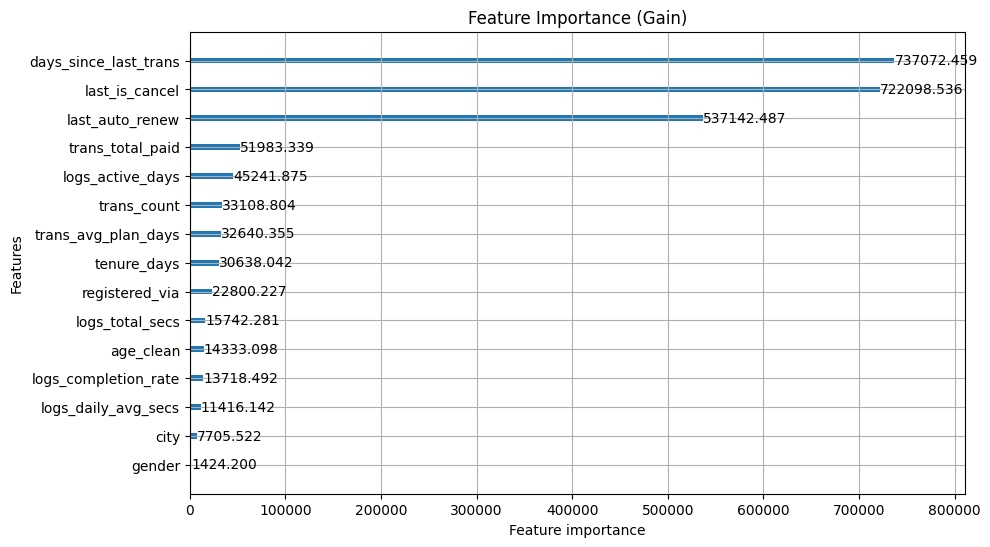

In [5]:
categorical_cols = ['city', 'gender', 'registered_via']

for col in categorical_cols:
    df_train[col] = df_train[col].astype('category')

X = df_train.drop(['msno', 'is_churn'], axis=1)
y = df_train['is_churn']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер обучения: {X_train.shape}")
print(f"Размер валидации: {X_val.shape}")

# 3. Обучение LightGBM
print("\nЗапуск обучения LightGBM...")

# Создаем датасеты для LGBM
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols)
dval = lgb.Dataset(X_val, label=y_val, reference=dtrain, categorical_feature=categorical_cols)

params = {
    'objective': 'binary',           # Задача классификации (0 или 1)
    'metric': 'binary_logloss',      # Метрика соревнования
    'boosting_type': 'gbdt',         # Классический бустинг
    'learning_rate': 0.05,           # Скорость обучения (помедленнее = точнее)
    'num_leaves': 31,                # Сложность дерева
    'max_depth': -1,                 # Глубина (без ограничений)
    'feature_fraction': 0.8,         # Брать 80% признаков для каждого дерева (защита от переобучения)
    'bagging_fraction': 0.8,         # Брать 80% строк
    'bagging_freq': 5,
    'verbose': -1,
    'n_jobs': -1                     # Использовать все ядра CPU
}

# Обучаем с ранней остановкой (если метрика не улучшается 50 итераций - стоп)
model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

# 4. Оценка результата
print("\nОценка модели:")
# Предсказания (вероятность ухода от 0 до 1)
preds = model.predict(X_val)
score = log_loss(y_val, preds)

print(f"VALIDATION LOG LOSS: {score:.5f}")

print("\nТоп-10 Важных признаков:")
lgb.plot_importance(model, max_num_features=15, importance_type='gain', figsize=(10, 6), title='Feature Importance (Gain)')
plt.show()

In [6]:
# 1. ЖЕСТКАЯ ОЧИСТКА
print("Полная очистка рабочей директории...")
os.system("rm -rf /kaggle/working/*") 

try:
    data_paths
except NameError:
    data_paths = get_data_paths()

con = duckdb.connect()

# === НАСТРОЙКИ SAFE MODE ===
con.execute("SET threads=1") 
con.execute("SET memory_limit='10GB'")
con.execute("SET preserve_insertion_order=false")

print("ЗАПУСК FIXED ETL (SAFE MODE)...")
start_time = time.time()

# =========================================================================
# ШАГ 1: Агрегация Логов (Optimized Variance)
# =========================================================================
print("\n[1/3]Считаем Логи...")

logs_query = f"""
    SELECT 
        msno,
        COUNT(DISTINCT date) as logs_active_days,
        SUM(total_secs) as logs_total_secs,
        SUM(total_secs * total_secs) as logs_sum_sq,
        
        -- WINDOW 1 (Jan 2017)
        SUM(CASE WHEN date >= 20170101 THEN total_secs ELSE 0 END) as secs_w1,
        COUNT(CASE WHEN date >= 20170101 THEN 1 ELSE NULL END) as days_w1,
        
        -- WINDOW 2 (Dec 2016)
        SUM(CASE WHEN date >= 20161201 AND date < 20170101 THEN total_secs ELSE 0 END) as secs_w2
        
    FROM '{data_paths['user_logs']}'
    WHERE msno IN (SELECT msno FROM '{data_paths['train']}')
    GROUP BY msno
"""
con.execute(f"COPY ({logs_query}) TO '/kaggle/working/temp_logs_safe.parquet' (FORMAT PARQUET)")

# =========================================================================
# ШАГ 2: Транзакции (ИСПРАВЛЕНО: Два подшага)
# =========================================================================
print("\n[2/3]Считаем Транзакции...")

# [2.1] Общая статистика (ВОТ ЧТО Я ПРОПУСТИЛ В ПРОШЛЫЙ РАЗ)
trans_stat_query = f"""
    SELECT 
        msno,
        COUNT(*) as trans_count,
        SUM(plan_list_price) as trans_total_paid,
        AVG(payment_plan_days) as trans_avg_plan_days
    FROM '{data_paths['transactions']}'
    WHERE msno IN (SELECT msno FROM '{data_paths['train']}')
    GROUP BY msno
"""
con.execute(f"COPY ({trans_stat_query}) TO '/kaggle/working/temp_trans_stat.parquet' (FORMAT PARQUET)")

# [2.2] Последний статус
trans_last_query = f"""
    SELECT 
        msno,
        is_auto_renew as last_auto_renew,
        is_cancel as last_is_cancel,
        transaction_date as last_trans_date_int,
        plan_list_price,
        actual_amount_paid,
        (plan_list_price - actual_amount_paid) as last_discount
    FROM '{data_paths['transactions']}'
    WHERE msno IN (SELECT msno FROM '{data_paths['train']}')
    QUALIFY ROW_NUMBER() OVER (PARTITION BY msno ORDER BY transaction_date DESC) = 1
"""
con.execute(f"COPY ({trans_last_query}) TO '/kaggle/working/temp_trans_last.parquet' (FORMAT PARQUET)")

# =========================================================================
# ШАГ 3: Финальная сборка
# =========================================================================
print("\n[3/3]Сборка Master Table...")

final_query = f"""
SELECT 
    t.msno,
    t.is_churn,
    
    -- PROFILE
    m.city,
    m.gender,
    m.registered_via,
    CASE WHEN bd < 5 OR bd > 80 THEN NULL ELSE bd END as age_clean,
    date_diff('day', TRY_CAST(strptime(CAST(registration_init_time AS VARCHAR), '%Y%m%d') AS DATE), DATE '2017-02-01') as tenure_days,
    
    -- LOGS
    COALESCE(l.logs_active_days, 0) as logs_active_days,
    COALESCE(l.logs_total_secs, 0) as logs_total_secs,
    CASE 
        WHEN l.logs_active_days > 1 THEN 
            SQRT(ABS((l.logs_sum_sq / l.logs_active_days) - POWER(l.logs_total_secs / l.logs_active_days, 2)))
        ELSE 0 
    END as logs_secs_stddev,
    (COALESCE(l.secs_w1, 0) - COALESCE(l.secs_w2, 0)) as trend_secs_diff,
    
    -- FINANCE STATS (ТЕПЕРЬ ОНИ ЕСТЬ)
    COALESCE(ts.trans_count, 0) as trans_count,
    COALESCE(ts.trans_total_paid, 0) as trans_total_paid,
    COALESCE(ts.trans_avg_plan_days, 0) as trans_avg_plan_days,
    
    -- FINANCE LAST
    COALESCE(tl.last_auto_renew, 0) as last_auto_renew,
    COALESCE(tl.last_is_cancel, 0) as last_is_cancel,
    COALESCE(tl.last_discount, 0) as last_discount,
    
    CASE 
        WHEN tl.last_trans_date_int IS NOT NULL 
        THEN date_diff('day', strptime(CAST(tl.last_trans_date_int AS VARCHAR), '%Y%m%d'), DATE '2017-02-01')
        ELSE 999 
    END as days_since_last_trans,
    
    -- INTERACTION
    CASE 
        WHEN l.days_w1 > 0 THEN (tl.actual_amount_paid / l.days_w1)
        ELSE 0 
    END as price_per_active_day

FROM '{data_paths['train']}' t
LEFT JOIN '{data_paths['members']}' m ON t.msno = m.msno
LEFT JOIN '/kaggle/working/temp_logs_safe.parquet' l ON t.msno = l.msno
LEFT JOIN '/kaggle/working/temp_trans_stat.parquet' ts ON t.msno = ts.msno
LEFT JOIN '/kaggle/working/temp_trans_last.parquet' tl ON t.msno = tl.msno
"""

df_train_advanced = con.execute(final_query).df()

# Очистка
os.system("rm /kaggle/working/temp_*.parquet")

print(f"\nУСПЕХ! Расширенная таблица готова. Размер: {df_train_advanced.shape}")
print(f"Колонки: {df_train_advanced.columns.tolist()}")

Полная очистка рабочей директории...
ЗАПУСК FIXED ETL (SAFE MODE)...

[1/3]Считаем Логи...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


[2/3]Считаем Транзакции...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


[3/3]Сборка Master Table...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


УСПЕХ! Расширенная таблица готова. Размер: (992931, 19)
Колонки: ['msno', 'is_churn', 'city', 'gender', 'registered_via', 'age_clean', 'tenure_days', 'logs_active_days', 'logs_total_secs', 'logs_secs_stddev', 'trend_secs_diff', 'trans_count', 'trans_total_paid', 'trans_avg_plan_days', 'last_auto_renew', 'last_is_cancel', 'last_discount', 'days_since_last_trans', 'price_per_active_day']


Обучение модели на расширенных данных...
Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.0682083	valid's binary_logloss: 0.0698172
[200]	train's binary_logloss: 0.0651265	valid's binary_logloss: 0.0686696
[300]	train's binary_logloss: 0.0632399	valid's binary_logloss: 0.0684086
[400]	train's binary_logloss: 0.0615557	valid's binary_logloss: 0.0683064
[500]	train's binary_logloss: 0.0600739	valid's binary_logloss: 0.0682505
Early stopping, best iteration is:
[513]	train's binary_logloss: 0.0598973	valid's binary_logloss: 0.0682439

ОТЧЕТ О РЕЗУЛЬТАТАХ МОДЕЛИРОВАНИЯ

1. Final Validation Log Loss: 0.06824

2. Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    185893
           1       0.79      0.75      0.77     12694

    accuracy                           0.97    198587
   macro avg       0.89      0.87      0.88    198587
weighted avg       0.97      0.97      0.97   

<Figure size 1200x800 with 0 Axes>

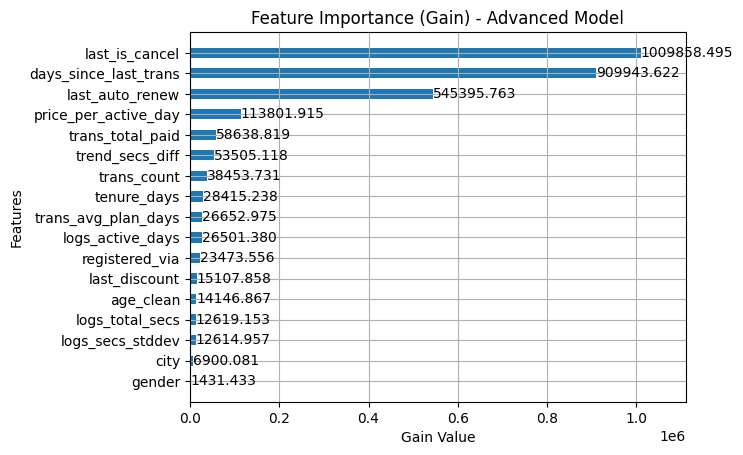

In [7]:
# 1. Подготовка
# Определяем категориальные признаки
categorical_cols = ['city', 'gender', 'registered_via']
for col in categorical_cols:
    df_train_advanced[col] = df_train_advanced[col].astype('category')

X = df_train_advanced.drop(['msno', 'is_churn'], axis=1)
y = df_train_advanced['is_churn']

# Разделение 80/20
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Обучение
print("Обучение модели на расширенных данных...")
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols)
dval = lgb.Dataset(X_val, label=y_val, reference=dtrain, categorical_feature=categorical_cols)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 40,        # Немного увеличили сложность, т.к. фичей стало больше
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'n_jobs': -1,
    'verbose': -1
}

model_adv = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'valid'],
    num_boost_round=1500,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

# 3. Отчет для курсовой работы
print("\n" + "="*50)
print("ОТЧЕТ О РЕЗУЛЬТАТАХ МОДЕЛИРОВАНИЯ")
print("="*50)

# Метрика Log Loss
preds = model_adv.predict(X_val)
loss = log_loss(y_val, preds)
print(f"\n1. Final Validation Log Loss: {loss:.5f}")

# Бинарная классификация (Порог 0.5)
y_pred_binary = (preds > 0.5).astype(int)
print("\n2. Classification Report:")
print(classification_report(y_val, y_pred_binary))

# 4. Визуализация Важности Признаков
print("\n3. Анализ Важности Признаков (Доказательство гипотез):")
plt.figure(figsize=(12, 8))
lgb.plot_importance(model_adv, max_num_features=20, importance_type='gain', height=0.5, 
                    title='Feature Importance (Gain) - Advanced Model', xlabel='Gain Value')
plt.show()

In [8]:
# 1. Определяем признаки
# Числовые (для масштабирования)
num_cols = [
    'age_clean', 'tenure_days', 
    'logs_active_days', 'logs_total_secs', 'logs_secs_stddev', 'trend_secs_diff',
    'trans_count', 'trans_total_paid', 'trans_avg_plan_days', 
    'days_since_last_trans', 'price_per_active_day', 'last_discount',
    'last_auto_renew', 'last_is_cancel' # Тоже нормализуем, хуже не будет
]

# Категориальные (для One-Hot)
cat_cols = ['city', 'gender', 'registered_via']

print("1. Подготовка данных для Нейросети...")

# Работаем с копией, чтобы не сломать оригинал
df_nn = df_train_advanced.copy()

# 2. Обработка пропусков (Заполняем нулями)
df_nn[num_cols] = df_nn[num_cols].fillna(0)

# 3. One-Hot Encoding
print("   ...кодирование категорий")
df_nn = pd.get_dummies(df_nn, columns=cat_cols, drop_first=True, dummy_na=True)

# 4. Нормализация (Standard Scaling)
print("   ...масштабирование чисел")
scaler = StandardScaler()
# Находим все колонки признаков (всё кроме msno и target)
feature_cols = [c for c in df_nn.columns if c not in ['msno', 'is_churn']]

# Масштабируем только числовые колонки
df_nn[num_cols] = scaler.fit_transform(df_nn[num_cols])

# 5. Создание тензоров
print("   ...конвертация в тензоры")
X = df_nn[feature_cols].values.astype(np.float32)
y = df_nn['is_churn'].values.astype(np.float32)

# Разделение (с тем же random_state, чтобы сравнение было честным)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# DataLoaders
batch_size = 2048 # Увеличим батч для скорости (данных много)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val), torch.tensor(y_val))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Данные готовы! Input Features: {X_train.shape[1]}")

1. Подготовка данных для Нейросети...
   ...кодирование категорий
   ...масштабирование чисел
   ...конвертация в тензоры
Данные готовы! Input Features: 42


DEVICE: cpu

Запуск обучения (20 эпох)...
Epoch 2/20 | Train: 0.0829 | Val: 0.0778
Epoch 4/20 | Train: 0.0783 | Val: 0.0760
Epoch 6/20 | Train: 0.0769 | Val: 0.0753
Epoch 8/20 | Train: 0.0761 | Val: 0.0747
Epoch 10/20 | Train: 0.0757 | Val: 0.0744
Epoch 12/20 | Train: 0.0753 | Val: 0.0742
Epoch 14/20 | Train: 0.0748 | Val: 0.0739
Epoch 16/20 | Train: 0.0747 | Val: 0.0738
Epoch 18/20 | Train: 0.0745 | Val: 0.0738
Epoch 20/20 | Train: 0.0742 | Val: 0.0736

Сравнение
1. PyTorch Log Loss:  0.07363
2. LightGBM Log Loss: 0.06824 (Baseline)

Classification Report (Neural Network):
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98    185893
         1.0       0.75      0.76      0.76     12694

    accuracy                           0.97    198587
   macro avg       0.87      0.87      0.87    198587
weighted avg       0.97      0.97      0.97    198587



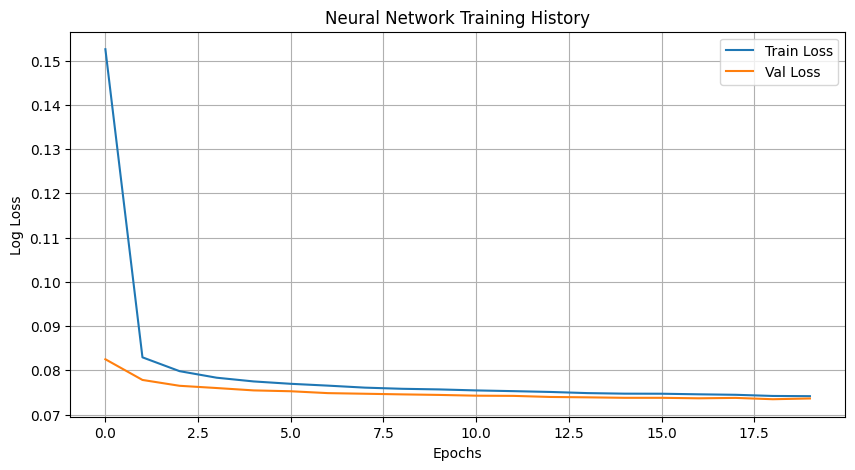

In [9]:
# Настройка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"DEVICE: {device}")

# === АРХИТЕКТУРА МОДЕЛИ ===
class ChurnModel(nn.Module):
    def __init__(self, input_dim):
        super(ChurnModel, self).__init__()
        
        self.net = nn.Sequential(
            # Слой 1
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Слой 2
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            # Выход
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Инициализация
model = ChurnModel(input_dim=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === ЦИКЛ ОБУЧЕНИЯ ===
epochs = 20
print(f"\nЗапуск обучения ({epochs} эпох)...")

history = {'train_loss': [], 'val_loss': []}

for epoch in range(epochs):
    # Train
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    # Val
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item() * inputs.size(0)
    
    # Logs
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_val_loss = val_loss / len(val_loader.dataset)
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train: {epoch_train_loss:.4f} | Val: {epoch_val_loss:.4f}")

# === ФИНАЛЬНОЕ СРАВНЕНИЕ ===
print("\n" + "="*40)
print("Сравнение")
print("="*40)

model.eval()
with torch.no_grad():
    y_val_preds_nn = model(torch.tensor(X_val).to(device)).cpu().numpy().squeeze()

nn_loss = log_loss(y_val, y_val_preds_nn)
y_pred_binary_nn = (y_val_preds_nn > 0.5).astype(int)

print(f"1. PyTorch Log Loss:  {nn_loss:.5f}")
print(f"2. LightGBM Log Loss: 0.06824 (Baseline)")

print("\nClassification Report (Neural Network):")
print(classification_report(y_val, y_pred_binary_nn))

# График обучения
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Neural Network Training History')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)
plt.show()